In [9]:
#chroma

Training model for spectrogram type: chroma
Epoch 1/50
14/14 [==============================] - 9s 615ms/step - loss: 0.6999 - accuracy: 0.5091 - val_loss: 0.6903 - val_accuracy: 0.5600
Epoch 2/50
14/14 [==============================] - 8s 541ms/step - loss: 0.6912 - accuracy: 0.5045 - val_loss: 0.6891 - val_accuracy: 0.5600
Epoch 3/50
14/14 [==============================] - 8s 562ms/step - loss: 0.6907 - accuracy: 0.5273 - val_loss: 0.6890 - val_accuracy: 0.5200
Epoch 4/50
14/14 [==============================] - 8s 586ms/step - loss: 0.6908 - accuracy: 0.5227 - val_loss: 0.6886 - val_accuracy: 0.5600
Epoch 5/50
14/14 [==============================] - 8s 569ms/step - loss: 0.6903 - accuracy: 0.5591 - val_loss: 0.6892 - val_accuracy: 0.5200
Epoch 6/50
14/14 [==============================] - 8s 561ms/step - loss: 0.6887 - accuracy: 0.5682 - val_loss: 0.6883 - val_accuracy: 0.6000
Epoch 7/50
14/14 [==============================] - 8s 573ms/step - loss: 0.6881 - accuracy: 0.5864 - va

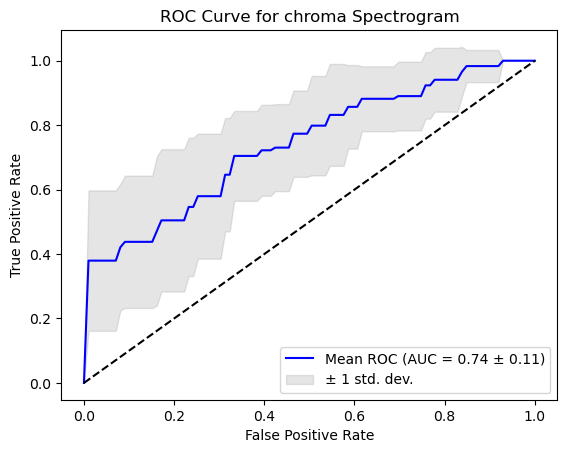


Mean and Std Dev of Performance Metrics for Spectrogram chroma:
Fold                   5.500000
Accuracy              66.550000
F1 Score               0.656667
Precision              0.687235
Recall                 0.665500
Specificity            0.762179
Kappa                  0.327145
ROC AUC                0.741162
Training Time (s)    134.927121
Testing Time (s)       1.366579
dtype: float64
Fold                   3.027650
Accuracy               9.961980
F1 Score               0.100272
Precision              0.120279
Recall                 0.099620
Specificity            0.187608
Kappa                  0.197845
ROC AUC                0.120113
Training Time (s)    158.892378
Testing Time (s)       0.409860
dtype: float64


In [10]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['chroma']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the ResNet50 model function
def build_resnet50_model(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_resnet50_model(input_shape, num_classes)

    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


Training model for spectrogram type: chroma
Epoch 1/50
14/14 [==============================] - 2s 178ms/step - loss: 0.8727 - accuracy: 0.4864 - val_loss: 0.7581 - val_accuracy: 0.3200
Epoch 2/50
14/14 [==============================] - 2s 136ms/step - loss: 0.6957 - accuracy: 0.5273 - val_loss: 0.7475 - val_accuracy: 0.3200
Epoch 3/50
14/14 [==============================] - 2s 136ms/step - loss: 0.6638 - accuracy: 0.6000 - val_loss: 0.7394 - val_accuracy: 0.5200
Epoch 4/50
14/14 [==============================] - 2s 133ms/step - loss: 0.6452 - accuracy: 0.6409 - val_loss: 0.7392 - val_accuracy: 0.4400
Epoch 5/50
14/14 [==============================] - 2s 137ms/step - loss: 0.6293 - accuracy: 0.6455 - val_loss: 0.7360 - val_accuracy: 0.5600
Epoch 6/50
14/14 [==============================] - 2s 135ms/step - loss: 0.6142 - accuracy: 0.6955 - val_loss: 0.7380 - val_accuracy: 0.5200
Epoch 7/50
14/14 [==============================] - 2s 135ms/step - loss: 0.6008 - accuracy: 0.7273 - va

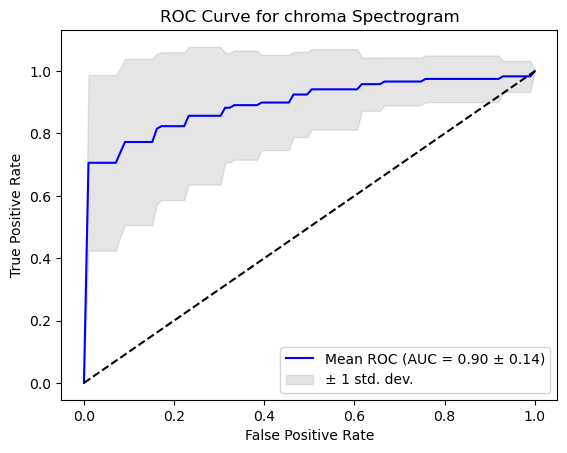


Mean and Std Dev of Performance Metrics for Spectrogram chroma:
Fold                  5.500000
Accuracy             84.566667
F1 Score              0.843902
Precision             0.853401
Recall                0.845667
Specificity           0.898077
Kappa                 0.689325
ROC AUC               0.898499
Training Time (s)    18.534958
Testing Time (s)      0.635415
dtype: float64
Fold                  3.027650
Accuracy             11.905285
F1 Score              0.121364
Precision             0.121513
Recall                0.119053
Specificity           0.103559
Kappa                 0.240630
ROC AUC               0.152054
Training Time (s)     9.533319
Testing Time (s)      0.089980
dtype: float64


In [11]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['chroma']


# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the MobileNetV2 model function
def build_mobilenetv2_model(input_shape, num_classes):
    base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_mobilenetv2_model(input_shape, num_classes)

    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


Training model for spectrogram type: chroma
Epoch 1/50
60/60 [==============================] - 118s 2s/step - loss: 0.6535 - accuracy: 0.6212 - val_loss: 0.6499 - val_accuracy: 0.6286
Epoch 2/50
60/60 [==============================] - 119s 2s/step - loss: 0.6419 - accuracy: 0.6307 - val_loss: 0.6479 - val_accuracy: 0.6286
Epoch 3/50
60/60 [==============================] - 121s 2s/step - loss: 0.6389 - accuracy: 0.6328 - val_loss: 0.6428 - val_accuracy: 0.6286
Epoch 4/50
60/60 [==============================] - 139s 2s/step - loss: 0.6343 - accuracy: 0.6381 - val_loss: 0.6414 - val_accuracy: 0.6476
Epoch 5/50
60/60 [==============================] - 186s 3s/step - loss: 0.6274 - accuracy: 0.6328 - val_loss: 0.6382 - val_accuracy: 0.6381
Epoch 6/50
60/60 [==============================] - 213s 4s/step - loss: 0.6256 - accuracy: 0.6413 - val_loss: 0.6368 - val_accuracy: 0.6476
Epoch 7/50
60/60 [==============================] - 223s 4s/step - loss: 0.6194 - accuracy: 0.6466 - val_loss:

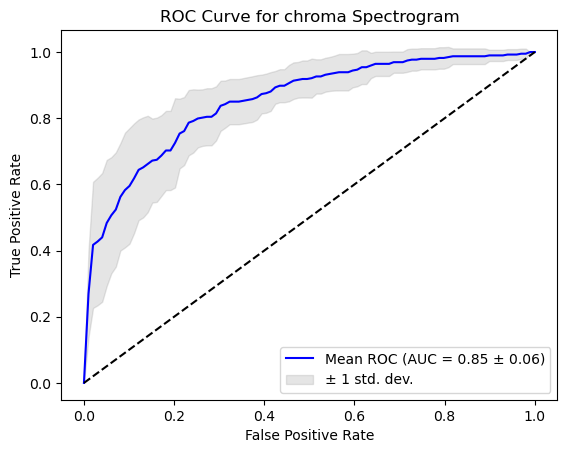


Mean and Std Dev of Performance Metrics for Spectrogram chroma:
Fold                    5.500000
Accuracy               78.666667
F1 Score                0.782032
Precision               0.784722
Recall                  0.786667
Specificity             0.875105
Kappa                   0.529509
ROC AUC                 0.851333
Training Time (s)    3155.789869
Testing Time (s)       11.417975
dtype: float64
Fold                    3.027650
Accuracy                4.860358
F1 Score                0.050708
Precision               0.051226
Recall                  0.048604
Specificity             0.041306
Kappa                   0.110199
ROC AUC                 0.063794
Training Time (s)    4581.001931
Testing Time (s)        1.253141
dtype: float64


In [12]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['chroma']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the VGG19 model function
def build_vgg19_model(input_shape, num_classes):
    base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_vgg19_model(input_shape, num_classes)

    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


In [ ]:
#Mel

Training model for spectrogram type: mel
Epoch 1/50
16/16 [==============================] - 22s 1s/step - loss: 0.7039 - accuracy: 0.4527 - val_loss: 0.6923 - val_accuracy: 0.5185
Epoch 2/50
16/16 [==============================] - 15s 965ms/step - loss: 0.6905 - accuracy: 0.5473 - val_loss: 0.6910 - val_accuracy: 0.5185
Epoch 3/50
16/16 [==============================] - 14s 901ms/step - loss: 0.6923 - accuracy: 0.5226 - val_loss: 0.6938 - val_accuracy: 0.5185
Epoch 4/50
16/16 [==============================] - 15s 942ms/step - loss: 0.6923 - accuracy: 0.5350 - val_loss: 0.6908 - val_accuracy: 0.5185
Epoch 5/50
16/16 [==============================] - 14s 903ms/step - loss: 0.6895 - accuracy: 0.5391 - val_loss: 0.6911 - val_accuracy: 0.5185
Epoch 6/50
16/16 [==============================] - 16s 969ms/step - loss: 0.6910 - accuracy: 0.5350 - val_loss: 0.6908 - val_accuracy: 0.5926
Epoch 7/50
16/16 [==============================] - 15s 926ms/step - loss: 0.6888 - accuracy: 0.5597 - v

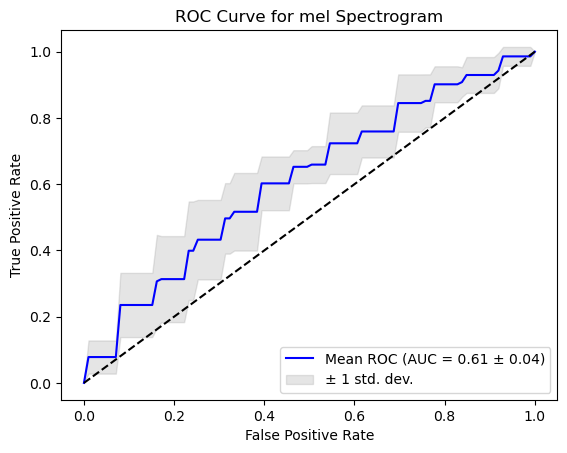


Mean and Std Dev of Performance Metrics for Spectrogram mel:
Fold                   5.500000
Accuracy              56.296296
F1 Score               0.542941
Precision              0.564260
Recall                 0.562963
Specificity            0.366026
Kappa                  0.112393
ROC AUC                0.612723
Training Time (s)    213.069772
Testing Time (s)       8.508105
dtype: float64
Fold                   3.027650
Accuracy               3.403469
F1 Score               0.045370
Precision              0.037510
Recall                 0.034035
Specificity            0.105999
Kappa                  0.071065
ROC AUC                0.043050
Training Time (s)    156.206477
Testing Time (s)       0.916578
dtype: float64


In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['mel']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the ResNet50 model function
def build_resnet50_model(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_resnet50_model(input_shape, num_classes)

    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


Training model for spectrogram type: mel
Epoch 1/50
14/14 [==============================] - 2s 119ms/step - loss: 0.7455 - accuracy: 0.4727 - val_loss: 0.7895 - val_accuracy: 0.5200
Epoch 2/50
14/14 [==============================] - 1s 84ms/step - loss: 0.6395 - accuracy: 0.6545 - val_loss: 0.7454 - val_accuracy: 0.4400
Epoch 3/50
14/14 [==============================] - 1s 91ms/step - loss: 0.6125 - accuracy: 0.7136 - val_loss: 0.7511 - val_accuracy: 0.4800
Epoch 4/50
14/14 [==============================] - 1s 84ms/step - loss: 0.5764 - accuracy: 0.7364 - val_loss: 0.7433 - val_accuracy: 0.4800
Epoch 5/50
14/14 [==============================] - 1s 85ms/step - loss: 0.5550 - accuracy: 0.7455 - val_loss: 0.7493 - val_accuracy: 0.4000
Epoch 6/50
14/14 [==============================] - 1s 85ms/step - loss: 0.5304 - accuracy: 0.7727 - val_loss: 0.7314 - val_accuracy: 0.4800
Epoch 7/50
14/14 [==============================] - 1s 87ms/step - loss: 0.5131 - accuracy: 0.8136 - val_loss: 0

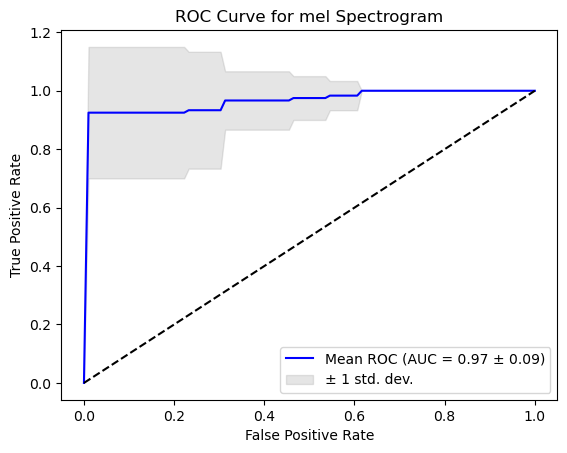


Mean and Std Dev of Performance Metrics for Spectrogram mel:
Fold                  5.500000
Accuracy             96.400000
F1 Score              0.963652
Precision             0.965200
Recall                0.964000
Specificity           0.953846
Kappa                 0.928571
ROC AUC               0.969231
Training Time (s)    20.975115
Testing Time (s)      0.566020
dtype: float64
Fold                  3.027650
Accuracy             11.384200
F1 Score              0.114942
Precision             0.110047
Recall                0.113842
Specificity           0.145951
Kappa                 0.225877
ROC AUC               0.097301
Training Time (s)    15.822890
Testing Time (s)      0.030152
dtype: float64


In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['mel']


# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the MobileNetV2 model function
def build_mobilenetv2_model(input_shape, num_classes):
    base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_mobilenetv2_model(input_shape, num_classes)

    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


Training model for spectrogram type: mel
Epoch 1/50
60/60 [==============================] - 69s 1s/step - loss: 0.6581 - accuracy: 0.6265 - val_loss: 0.6618 - val_accuracy: 0.6286
Epoch 2/50
60/60 [==============================] - 68s 1s/step - loss: 0.6435 - accuracy: 0.6286 - val_loss: 0.6557 - val_accuracy: 0.6286
Epoch 3/50
60/60 [==============================] - 68s 1s/step - loss: 0.6333 - accuracy: 0.6349 - val_loss: 0.6458 - val_accuracy: 0.6381
Epoch 4/50
60/60 [==============================] - 105s 2s/step - loss: 0.6216 - accuracy: 0.6360 - val_loss: 0.6382 - val_accuracy: 0.6381
Epoch 5/50
60/60 [==============================] - 122s 2s/step - loss: 0.6134 - accuracy: 0.6582 - val_loss: 0.6284 - val_accuracy: 0.6476
Epoch 6/50
60/60 [==============================] - 121s 2s/step - loss: 0.6063 - accuracy: 0.6561 - val_loss: 0.6331 - val_accuracy: 0.6381
Epoch 7/50
60/60 [==============================] - 121s 2s/step - loss: 0.6015 - accuracy: 0.6667 - val_loss: 0.620

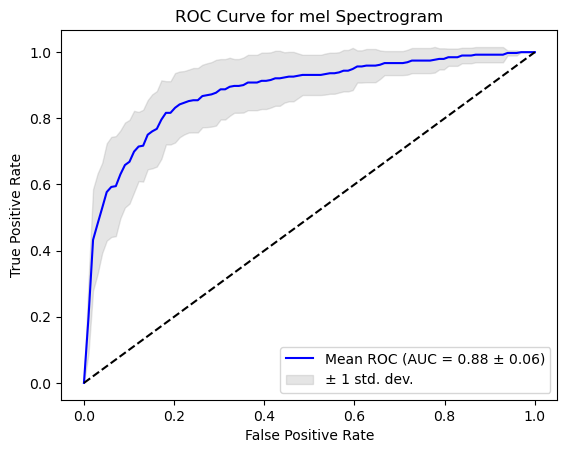


Mean and Std Dev of Performance Metrics for Spectrogram mel:
Fold                    5.500000
Accuracy               81.523810
F1 Score                0.811721
Precision               0.813452
Recall                  0.815238
Specificity             0.891935
Kappa                   0.593313
ROC AUC                 0.880044
Training Time (s)    3673.619626
Testing Time (s)       18.875280
dtype: float64
Fold                    3.027650
Accuracy                5.200926
F1 Score                0.054012
Precision               0.053832
Recall                  0.052009
Specificity             0.030740
Kappa                   0.118370
ROC AUC                 0.061403
Training Time (s)    4932.358430
Testing Time (s)        1.925022
dtype: float64


In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['mel']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the VGG19 model function
def build_vgg19_model(input_shape, num_classes):
    base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_vgg19_model(input_shape, num_classes)

    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


In [ ]:
#FOR MFCC

Training model for spectrogram type: mfcc
Epoch 1/50
16/16 [==============================] - 14s 881ms/step - loss: 0.7016 - accuracy: 0.4650 - val_loss: 0.6928 - val_accuracy: 0.5185
Epoch 2/50
16/16 [==============================] - 12s 721ms/step - loss: 0.6956 - accuracy: 0.4774 - val_loss: 0.6929 - val_accuracy: 0.5185
Epoch 3/50
16/16 [==============================] - 11s 704ms/step - loss: 0.6950 - accuracy: 0.5062 - val_loss: 0.6925 - val_accuracy: 0.5185
Epoch 4/50
16/16 [==============================] - 11s 706ms/step - loss: 0.6920 - accuracy: 0.5226 - val_loss: 0.6924 - val_accuracy: 0.5185
Epoch 5/50
16/16 [==============================] - 11s 707ms/step - loss: 0.6924 - accuracy: 0.5226 - val_loss: 0.6926 - val_accuracy: 0.5185
Epoch 6/50
16/16 [==============================] - 12s 721ms/step - loss: 0.6928 - accuracy: 0.5226 - val_loss: 0.6924 - val_accuracy: 0.5185
Epoch 7/50
16/16 [==============================] - 11s 703ms/step - loss: 0.6924 - accuracy: 0.5226

C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
16/16 [==============================] - 14s 902ms/step - loss: 0.6950 - accuracy: 0.5226 - val_loss: 0.6920 - val_accuracy: 0.5185
Epoch 2/50
16/16 [==============================] - 11s 706ms/step - loss: 0.6963 - accuracy: 0.4156 - val_loss: 0.6920 - val_accuracy: 0.5185
Epoch 3/50
16/16 [==============================] - 11s 711ms/step - loss: 0.6925 - accuracy: 0.5226 - val_loss: 0.6928 - val_accuracy: 0.5185
Epoch 4/50
16/16 [==============================] - 11s 687ms/step - loss: 0.6927 - accuracy: 0.5226 - val_loss: 0.6921 - val_accuracy: 0.5185
Epoch 5/50
16/16 [==============================] - 11s 703ms/step - loss: 0.6967 - accuracy: 0.4444 - val_loss: 0.6932 - val_accuracy: 0.4815
Epoch 6/50
16/16 [==============================] - 11s 715ms/step - loss: 0.6964 - accuracy: 0.5103 - val_loss: 0.6935 - val_accuracy: 0.5185
Epoch 7/50
16/16 [==============================] - 11s 704ms/step - loss: 0.6938 - accuracy: 0.5226 - val_loss: 0.6932 - val_accuracy: 0.5185

C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
16/16 [==============================] - 15s 913ms/step - loss: 0.6944 - accuracy: 0.5226 - val_loss: 0.6917 - val_accuracy: 0.5185
Epoch 2/50
16/16 [==============================] - 11s 713ms/step - loss: 0.6924 - accuracy: 0.5226 - val_loss: 0.6917 - val_accuracy: 0.5185
Epoch 3/50
16/16 [==============================] - 11s 693ms/step - loss: 0.6950 - accuracy: 0.4321 - val_loss: 0.6922 - val_accuracy: 0.5926
Epoch 4/50
16/16 [==============================] - 11s 710ms/step - loss: 0.6925 - accuracy: 0.5267 - val_loss: 0.6918 - val_accuracy: 0.5185
Epoch 5/50
16/16 [==============================] - 11s 699ms/step - loss: 0.6925 - accuracy: 0.5226 - val_loss: 0.6928 - val_accuracy: 0.5185
Epoch 6/50
16/16 [==============================] - 11s 708ms/step - loss: 0.6957 - accuracy: 0.5226 - val_loss: 0.6917 - val_accuracy: 0.5185
Epoch 7/50
16/16 [==============================] - 12s 722ms/step - loss: 0.6940 - accuracy: 0.5226 - val_loss: 0.6915 - val_accuracy: 0.5185

C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
16/16 [==============================] - 22s 1s/step - loss: 0.6927 - accuracy: 0.5226 - val_loss: 0.6911 - val_accuracy: 0.5185
Epoch 2/50
16/16 [==============================] - 12s 740ms/step - loss: 0.6929 - accuracy: 0.5226 - val_loss: 0.6910 - val_accuracy: 0.5185
Epoch 3/50
16/16 [==============================] - 12s 746ms/step - loss: 0.6923 - accuracy: 0.5226 - val_loss: 0.6915 - val_accuracy: 0.5185
Epoch 4/50
16/16 [==============================] - 11s 709ms/step - loss: 0.6919 - accuracy: 0.5226 - val_loss: 0.6911 - val_accuracy: 0.5185
Epoch 5/50
16/16 [==============================] - 12s 720ms/step - loss: 0.6921 - accuracy: 0.5226 - val_loss: 0.6910 - val_accuracy: 0.5185
Epoch 6/50
16/16 [==============================] - 12s 754ms/step - loss: 0.6939 - accuracy: 0.4733 - val_loss: 0.6913 - val_accuracy: 0.5556
Epoch 7/50
16/16 [==============================] - 12s 750ms/step - loss: 0.6958 - accuracy: 0.5226 - val_loss: 0.6946 - val_accuracy: 0.5185
Ep

C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


16/16 [==============================] - 14s 855ms/step - loss: 0.6943 - accuracy: 0.5062 - val_loss: 0.6922 - val_accuracy: 0.5185
Epoch 2/50
16/16 [==============================] - 11s 714ms/step - loss: 0.6926 - accuracy: 0.5226 - val_loss: 0.6919 - val_accuracy: 0.5185
Epoch 3/50
16/16 [==============================] - 11s 696ms/step - loss: 0.6910 - accuracy: 0.5226 - val_loss: 0.6917 - val_accuracy: 0.5185
Epoch 4/50
16/16 [==============================] - 11s 693ms/step - loss: 0.6919 - accuracy: 0.5144 - val_loss: 0.6917 - val_accuracy: 0.5556
Epoch 5/50
16/16 [==============================] - 12s 724ms/step - loss: 0.6949 - accuracy: 0.4156 - val_loss: 0.6915 - val_accuracy: 0.5185
Epoch 6/50
16/16 [==============================] - 11s 689ms/step - loss: 0.6910 - accuracy: 0.5226 - val_loss: 0.6917 - val_accuracy: 0.5185
Epoch 7/50
16/16 [==============================] - 11s 717ms/step - loss: 0.6928 - accuracy: 0.5226 - val_loss: 0.6915 - val_accuracy: 0.5185
Epoch 8/50

C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


16/16 [==============================] - 14s 845ms/step - loss: 0.6948 - accuracy: 0.4486 - val_loss: 0.6916 - val_accuracy: 0.5185
Epoch 2/50
16/16 [==============================] - 12s 725ms/step - loss: 0.6918 - accuracy: 0.5226 - val_loss: 0.6934 - val_accuracy: 0.5185
Epoch 3/50
16/16 [==============================] - 11s 688ms/step - loss: 0.6929 - accuracy: 0.5226 - val_loss: 0.6920 - val_accuracy: 0.5185
Epoch 4/50
16/16 [==============================] - 11s 686ms/step - loss: 0.6910 - accuracy: 0.5226 - val_loss: 0.6918 - val_accuracy: 0.5185
Epoch 5/50
16/16 [==============================] - 11s 680ms/step - loss: 0.6928 - accuracy: 0.5226 - val_loss: 0.6917 - val_accuracy: 0.5185
Epoch 6/50
16/16 [==============================] - 11s 717ms/step - loss: 0.6921 - accuracy: 0.5226 - val_loss: 0.6932 - val_accuracy: 0.5185
Fold 6 Results: Accuracy=51.85%, F1=0.35, Precision=0.27, Recall=0.52, Specificity=0.00, Kappa=0.00, ROC AUC=0.57


C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
16/16 [==============================] - 15s 918ms/step - loss: 0.6962 - accuracy: 0.5350 - val_loss: 0.6899 - val_accuracy: 0.5185
Epoch 2/50
16/16 [==============================] - 12s 740ms/step - loss: 0.6915 - accuracy: 0.5432 - val_loss: 0.6905 - val_accuracy: 0.6667
Epoch 3/50
16/16 [==============================] - 12s 758ms/step - loss: 0.6929 - accuracy: 0.4979 - val_loss: 0.6899 - val_accuracy: 0.5185
Epoch 4/50
16/16 [==============================] - 12s 762ms/step - loss: 0.6908 - accuracy: 0.5226 - val_loss: 0.6909 - val_accuracy: 0.5185
Epoch 5/50
16/16 [==============================] - 12s 748ms/step - loss: 0.6917 - accuracy: 0.5226 - val_loss: 0.6899 - val_accuracy: 0.5185
Epoch 6/50
16/16 [==============================] - 12s 764ms/step - loss: 0.6925 - accuracy: 0.5226 - val_loss: 0.6899 - val_accuracy: 0.5185
Fold 7 Results: Accuracy=51.85%, F1=0.35, Precision=0.27, Recall=0.52, Specificity=0.00, Kappa=0.00, ROC AUC=0.74
Epoch 1/50


C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


16/16 [==============================] - 16s 1s/step - loss: 0.6926 - accuracy: 0.5226 - val_loss: 0.6930 - val_accuracy: 0.5185
Epoch 2/50
16/16 [==============================] - 14s 881ms/step - loss: 0.6917 - accuracy: 0.5226 - val_loss: 0.6951 - val_accuracy: 0.5185
Epoch 3/50
16/16 [==============================] - 14s 896ms/step - loss: 0.6931 - accuracy: 0.5226 - val_loss: 0.6946 - val_accuracy: 0.5185
Epoch 4/50
16/16 [==============================] - 14s 880ms/step - loss: 0.6913 - accuracy: 0.5226 - val_loss: 0.6931 - val_accuracy: 0.5185
Epoch 5/50
16/16 [==============================] - 14s 848ms/step - loss: 0.6914 - accuracy: 0.5350 - val_loss: 0.6958 - val_accuracy: 0.4815
Epoch 6/50
16/16 [==============================] - 14s 875ms/step - loss: 0.6966 - accuracy: 0.4774 - val_loss: 0.6947 - val_accuracy: 0.4815
Fold 8 Results: Accuracy=51.85%, F1=0.35, Precision=0.27, Recall=0.52, Specificity=0.00, Kappa=0.00, ROC AUC=0.46
Epoch 1/50


C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


16/16 [==============================] - 16s 1s/step - loss: 0.6942 - accuracy: 0.4815 - val_loss: 0.6916 - val_accuracy: 0.5185
Epoch 2/50
16/16 [==============================] - 15s 937ms/step - loss: 0.6909 - accuracy: 0.5226 - val_loss: 0.6914 - val_accuracy: 0.5185
Epoch 3/50
16/16 [==============================] - 15s 960ms/step - loss: 0.6920 - accuracy: 0.5226 - val_loss: 0.6913 - val_accuracy: 0.5185
Epoch 4/50
16/16 [==============================] - 15s 956ms/step - loss: 0.6919 - accuracy: 0.5226 - val_loss: 0.6913 - val_accuracy: 0.5185
Epoch 5/50
16/16 [==============================] - 14s 895ms/step - loss: 0.6917 - accuracy: 0.5226 - val_loss: 0.6913 - val_accuracy: 0.5185
Epoch 6/50
16/16 [==============================] - 15s 913ms/step - loss: 0.6912 - accuracy: 0.5226 - val_loss: 0.6913 - val_accuracy: 0.5185
Epoch 7/50
16/16 [==============================] - 15s 913ms/step - loss: 0.6924 - accuracy: 0.5226 - val_loss: 0.6912 - val_accuracy: 0.5185
Epoch 8/50
16

C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


16/16 [==============================] - 18s 1s/step - loss: 0.6945 - accuracy: 0.4815 - val_loss: 0.6888 - val_accuracy: 0.5556
Epoch 2/50
16/16 [==============================] - 15s 958ms/step - loss: 0.6918 - accuracy: 0.5185 - val_loss: 0.6897 - val_accuracy: 0.5556
Epoch 3/50
16/16 [==============================] - 15s 962ms/step - loss: 0.6921 - accuracy: 0.5185 - val_loss: 0.6880 - val_accuracy: 0.5556
Epoch 4/50
16/16 [==============================] - 15s 945ms/step - loss: 0.6911 - accuracy: 0.5226 - val_loss: 0.6922 - val_accuracy: 0.4444
Epoch 5/50
16/16 [==============================] - 15s 958ms/step - loss: 0.6922 - accuracy: 0.5185 - val_loss: 0.6900 - val_accuracy: 0.5556
Epoch 6/50
16/16 [==============================] - 15s 936ms/step - loss: 0.6924 - accuracy: 0.5185 - val_loss: 0.6927 - val_accuracy: 0.5926
Epoch 7/50
16/16 [==============================] - 15s 953ms/step - loss: 0.6918 - accuracy: 0.5309 - val_loss: 0.6888 - val_accuracy: 0.5556
Epoch 8/50
16

C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


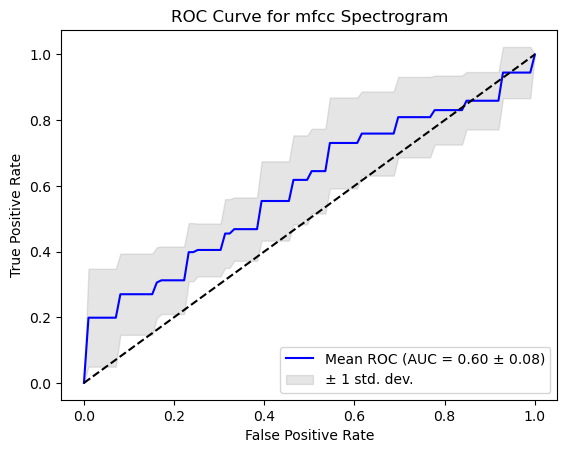


Mean and Std Dev of Performance Metrics for Spectrogram mfcc:
Fold                   5.500000
Accuracy              52.222222
F1 Score               0.358382
Precision              0.272840
Recall                 0.522222
Specificity            0.000000
Kappa                  0.000000
ROC AUC                0.597283
Training Time (s)    187.560125
Testing Time (s)       3.564393
dtype: float64
Fold                   3.027650
Accuracy               1.171214
F1 Score               0.013508
Precision              0.012580
Recall                 0.011712
Specificity            0.000000
Kappa                  0.000000
ROC AUC                0.084937
Training Time (s)    159.995676
Testing Time (s)       0.277981
dtype: float64


In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['mfcc']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the ResNet50 model function
def build_resnet50_model(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_resnet50_model(input_shape, num_classes)

    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


Training model for spectrogram type: mfcc
Epoch 1/50
14/14 [==============================] - 2s 145ms/step - loss: 0.7376 - accuracy: 0.4773 - val_loss: 0.6884 - val_accuracy: 0.6400
Epoch 2/50
14/14 [==============================] - 1s 104ms/step - loss: 0.6911 - accuracy: 0.5273 - val_loss: 0.6808 - val_accuracy: 0.6400
Epoch 3/50
14/14 [==============================] - 1s 91ms/step - loss: 0.6671 - accuracy: 0.5909 - val_loss: 0.6758 - val_accuracy: 0.6800
Epoch 4/50
14/14 [==============================] - 1s 101ms/step - loss: 0.6487 - accuracy: 0.6591 - val_loss: 0.6736 - val_accuracy: 0.6000
Epoch 5/50
14/14 [==============================] - 1s 92ms/step - loss: 0.6399 - accuracy: 0.6545 - val_loss: 0.6679 - val_accuracy: 0.6000
Epoch 6/50
14/14 [==============================] - 1s 96ms/step - loss: 0.6160 - accuracy: 0.6955 - val_loss: 0.6606 - val_accuracy: 0.5600
Epoch 7/50
14/14 [==============================] - 1s 102ms/step - loss: 0.6153 - accuracy: 0.6955 - val_los

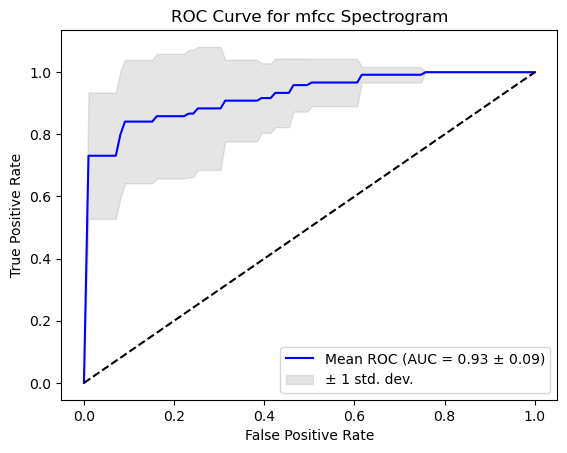


Mean and Std Dev of Performance Metrics for Spectrogram mfcc:
Fold                  5.500000
Accuracy             85.350000
F1 Score              0.852996
Precision             0.856900
Recall                0.853500
Specificity           0.841026
Kappa                 0.706507
ROC AUC               0.927331
Training Time (s)    17.808099
Testing Time (s)      0.715611
dtype: float64
Fold                  3.027650
Accuracy             11.590079
F1 Score              0.116850
Precision             0.117440
Recall                0.115901
Specificity           0.098513
Kappa                 0.233375
ROC AUC               0.095031
Training Time (s)     9.771119
Testing Time (s)      0.179330
dtype: float64


In [4]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['mfcc']


# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the MobileNetV2 model function
def build_mobilenetv2_model(input_shape, num_classes):
    base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_mobilenetv2_model(input_shape, num_classes)

    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


Training model for spectrogram type: mfcc
Epoch 1/50
60/60 [==============================] - 57s 956ms/step - loss: 0.6730 - accuracy: 0.5937 - val_loss: 0.6558 - val_accuracy: 0.6286
Epoch 2/50
60/60 [==============================] - 60s 1s/step - loss: 0.6596 - accuracy: 0.6254 - val_loss: 0.6540 - val_accuracy: 0.6286
Epoch 3/50
60/60 [==============================] - 66s 1s/step - loss: 0.6593 - accuracy: 0.6254 - val_loss: 0.6513 - val_accuracy: 0.6286
Epoch 4/50
60/60 [==============================] - 66s 1s/step - loss: 0.6564 - accuracy: 0.6254 - val_loss: 0.6515 - val_accuracy: 0.6286
Epoch 5/50
60/60 [==============================] - 66s 1s/step - loss: 0.6561 - accuracy: 0.6254 - val_loss: 0.6481 - val_accuracy: 0.6286
Epoch 6/50
60/60 [==============================] - 66s 1s/step - loss: 0.6533 - accuracy: 0.6254 - val_loss: 0.6475 - val_accuracy: 0.6286
Epoch 7/50
60/60 [==============================] - 65s 1s/step - loss: 0.6517 - accuracy: 0.6254 - val_loss: 0.644

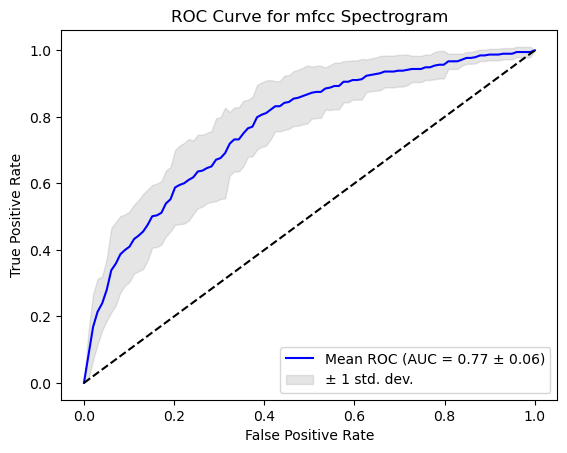


Mean and Std Dev of Performance Metrics for Spectrogram mfcc:
Fold                    5.500000
Accuracy               71.142857
F1 Score                0.684981
Precision               0.709573
Recall                  0.711429
Specificity             0.894779
Kappa                   0.323139
ROC AUC                 0.769319
Training Time (s)    1441.944025
Testing Time (s)        6.775880
dtype: float64
Fold                    3.027650
Accuracy                3.648723
F1 Score                0.054426
Precision               0.040124
Recall                  0.036487
Specificity             0.042123
Kappa                   0.109517
ROC AUC                 0.060899
Training Time (s)    1233.742865
Testing Time (s)        0.327474
dtype: float64


In [5]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['mfcc']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the VGG19 model function
def build_vgg19_model(input_shape, num_classes):
    base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_vgg19_model(input_shape, num_classes)

    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


In [ ]:
#for cqt

Training model for spectrogram type: cqt
Epoch 1/50
16/16 [==============================] - 16s 1s/step - loss: 0.7036 - accuracy: 0.5103 - val_loss: 0.6913 - val_accuracy: 0.5185
Epoch 2/50
16/16 [==============================] - 14s 888ms/step - loss: 0.6932 - accuracy: 0.5185 - val_loss: 0.6915 - val_accuracy: 0.5185
Epoch 3/50
16/16 [==============================] - 14s 875ms/step - loss: 0.6937 - accuracy: 0.4979 - val_loss: 0.6916 - val_accuracy: 0.5185
Epoch 4/50
16/16 [==============================] - 15s 908ms/step - loss: 0.6915 - accuracy: 0.5350 - val_loss: 0.6917 - val_accuracy: 0.5185
Epoch 5/50
16/16 [==============================] - 14s 887ms/step - loss: 0.6907 - accuracy: 0.5226 - val_loss: 0.6919 - val_accuracy: 0.5185
Epoch 6/50
16/16 [==============================] - 14s 900ms/step - loss: 0.6905 - accuracy: 0.5226 - val_loss: 0.6903 - val_accuracy: 0.4815
Epoch 7/50
16/16 [==============================] - 14s 883ms/step - loss: 0.6894 - accuracy: 0.5432 - v

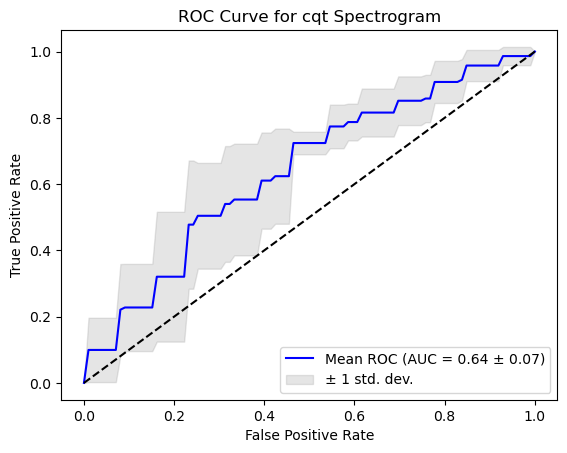


Mean and Std Dev of Performance Metrics for Spectrogram cqt:
Fold                   5.500000
Accuracy              62.222222
F1 Score               0.610315
Precision              0.626791
Recall                 0.622222
Specificity            0.471795
Kappa                  0.232575
ROC AUC                0.641294
Training Time (s)    352.317119
Testing Time (s)       3.999600
dtype: float64
Fold                   3.027650
Accuracy               4.552861
F1 Score               0.054181
Precision              0.045463
Recall                 0.045529
Specificity            0.124564
Kappa                  0.097920
ROC AUC                0.070708
Training Time (s)    399.589383
Testing Time (s)       0.632584
dtype: float64


In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['cqt']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the ResNet50 model function
def build_resnet50_model(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_resnet50_model(input_shape, num_classes)

    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


Training model for spectrogram type: cqt
Epoch 1/50
14/14 [==============================] - 2s 142ms/step - loss: 0.7326 - accuracy: 0.5136 - val_loss: 0.7405 - val_accuracy: 0.4800
Epoch 2/50
14/14 [==============================] - 2s 115ms/step - loss: 0.6504 - accuracy: 0.6182 - val_loss: 0.7262 - val_accuracy: 0.6400
Epoch 3/50
14/14 [==============================] - 1s 98ms/step - loss: 0.6031 - accuracy: 0.6727 - val_loss: 0.7076 - val_accuracy: 0.6000
Epoch 4/50
14/14 [==============================] - 1s 101ms/step - loss: 0.5576 - accuracy: 0.7545 - val_loss: 0.7226 - val_accuracy: 0.6800
Epoch 5/50
14/14 [==============================] - 2s 108ms/step - loss: 0.5278 - accuracy: 0.7909 - val_loss: 0.6982 - val_accuracy: 0.6000
Epoch 6/50
14/14 [==============================] - 2s 110ms/step - loss: 0.5041 - accuracy: 0.7955 - val_loss: 0.6944 - val_accuracy: 0.6800
Epoch 7/50
14/14 [==============================] - 1s 107ms/step - loss: 0.4715 - accuracy: 0.8591 - val_lo

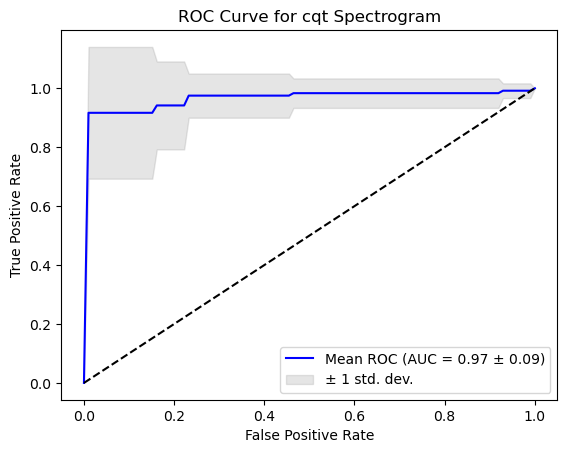


Mean and Std Dev of Performance Metrics for Spectrogram cqt:
Fold                  5.500000
Accuracy             95.200000
F1 Score              0.951291
Precision             0.952808
Recall                0.952000
Specificity           0.961538
Kappa                 0.903172
ROC AUC               0.968590
Training Time (s)    25.068258
Testing Time (s)      0.760289
dtype: float64
Fold                  3.027650
Accuracy             11.282238
F1 Score              0.115003
Precision             0.111314
Recall                0.112822
Specificity           0.074756
Kappa                 0.228160
ROC AUC               0.092768
Training Time (s)    25.118410
Testing Time (s)      0.138394
dtype: float64


In [6]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['cqt']


# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the MobileNetV2 model function
def build_mobilenetv2_model(input_shape, num_classes):
    base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_mobilenetv2_model(input_shape, num_classes)

    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


Training model for spectrogram type: cqt
Epoch 1/50
60/60 [==============================] - 82s 1s/step - loss: 0.7031 - accuracy: 0.5640 - val_loss: 0.6687 - val_accuracy: 0.6286
Epoch 2/50
60/60 [==============================] - 84s 1s/step - loss: 0.6563 - accuracy: 0.6286 - val_loss: 0.6707 - val_accuracy: 0.6190
Epoch 3/50
60/60 [==============================] - 83s 1s/step - loss: 0.6453 - accuracy: 0.6222 - val_loss: 0.6734 - val_accuracy: 0.6190
Epoch 4/50
60/60 [==============================] - 84s 1s/step - loss: 0.6392 - accuracy: 0.6275 - val_loss: 0.6803 - val_accuracy: 0.6000
Epoch 5/50
60/60 [==============================] - 83s 1s/step - loss: 0.6343 - accuracy: 0.6677 - val_loss: 0.6728 - val_accuracy: 0.6286
Epoch 6/50
60/60 [==============================] - 83s 1s/step - loss: 0.6252 - accuracy: 0.6476 - val_loss: 0.6730 - val_accuracy: 0.6381


C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 1 Results: Accuracy=62.86%, F1=0.49, Precision=0.40, Recall=0.63, Specificity=1.00, Kappa=0.00, ROC AUC=0.41
Epoch 1/50
60/60 [==============================] - 85s 1s/step - loss: 0.6565 - accuracy: 0.6243 - val_loss: 0.6617 - val_accuracy: 0.6286
Epoch 2/50
60/60 [==============================] - 83s 1s/step - loss: 0.6509 - accuracy: 0.6275 - val_loss: 0.6559 - val_accuracy: 0.6286
Epoch 3/50
60/60 [==============================] - 83s 1s/step - loss: 0.6420 - accuracy: 0.6222 - val_loss: 0.6416 - val_accuracy: 0.6286
Epoch 4/50
60/60 [==============================] - 83s 1s/step - loss: 0.6349 - accuracy: 0.6392 - val_loss: 0.6398 - val_accuracy: 0.6286
Epoch 5/50
60/60 [==============================] - 83s 1s/step - loss: 0.6301 - accuracy: 0.6307 - val_loss: 0.6299 - val_accuracy: 0.6190
Epoch 6/50
60/60 [==============================] - 83s 1s/step - loss: 0.6232 - accuracy: 0.6402 - val_loss: 0.6309 - val_accuracy: 0.6190
Epoch 7/50
60/60 [============================

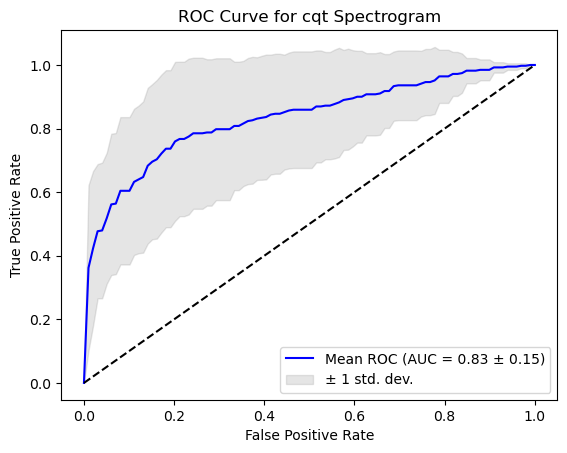


Mean and Std Dev of Performance Metrics for Spectrogram cqt:
Fold                    5.500000
Accuracy               80.285714
F1 Score                0.783168
Precision               0.780008
Recall                  0.802857
Specificity             0.928508
Kappa                   0.541778
ROC AUC                 0.833420
Training Time (s)    2423.386162
Testing Time (s)        8.550931
dtype: float64
Fold                    3.027650
Accuracy                7.956166
F1 Score                0.118153
Precision               0.145089
Recall                  0.079562
Specificity             0.037126
Kappa                   0.225255
ROC AUC                 0.160017
Training Time (s)    4064.076018
Testing Time (s)        1.196080
dtype: float64


In [7]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['cqt']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the VGG19 model function
def build_vgg19_model(input_shape, num_classes):
    base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_vgg19_model(input_shape, num_classes)

    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


In [ ]:
#for stft

Training model for spectrogram type: stft
Epoch 1/50
14/14 [==============================] - 28s 2s/step - loss: 0.7041 - accuracy: 0.5091 - val_loss: 0.6880 - val_accuracy: 0.6400
Epoch 2/50
14/14 [==============================] - 24s 2s/step - loss: 0.6979 - accuracy: 0.4591 - val_loss: 0.6929 - val_accuracy: 0.5200
Epoch 3/50
14/14 [==============================] - 24s 2s/step - loss: 0.6912 - accuracy: 0.4909 - val_loss: 0.6871 - val_accuracy: 0.5200
Epoch 4/50
14/14 [==============================] - 23s 2s/step - loss: 0.6903 - accuracy: 0.5136 - val_loss: 0.6873 - val_accuracy: 0.5200
Epoch 5/50
14/14 [==============================] - 24s 2s/step - loss: 0.6910 - accuracy: 0.5136 - val_loss: 0.6885 - val_accuracy: 0.5600
Epoch 6/50
14/14 [==============================] - 24s 2s/step - loss: 0.6905 - accuracy: 0.5136 - val_loss: 0.6878 - val_accuracy: 0.5200
Epoch 7/50
14/14 [==============================] - 24s 2s/step - loss: 0.6898 - accuracy: 0.5136 - val_loss: 0.6876 -

C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
14/14 [==============================] - 30s 2s/step - loss: 0.6955 - accuracy: 0.4636 - val_loss: 0.6969 - val_accuracy: 0.5600
Epoch 2/50
14/14 [==============================] - 22s 2s/step - loss: 0.6896 - accuracy: 0.5136 - val_loss: 0.6989 - val_accuracy: 0.5200
Epoch 3/50
14/14 [==============================] - 23s 2s/step - loss: 0.6886 - accuracy: 0.5227 - val_loss: 0.6986 - val_accuracy: 0.4400
Epoch 4/50
14/14 [==============================] - 23s 2s/step - loss: 0.6877 - accuracy: 0.5227 - val_loss: 0.6990 - val_accuracy: 0.4000
Epoch 5/50
14/14 [==============================] - 25s 2s/step - loss: 0.6875 - accuracy: 0.5182 - val_loss: 0.7002 - val_accuracy: 0.3600
Epoch 6/50
14/14 [==============================] - 25s 2s/step - loss: 0.6878 - accuracy: 0.5091 - val_loss: 0.7012 - val_accuracy: 0.4800
Fold 2 Results: Accuracy=56.00%, F1=0.53, Precision=0.60, Recall=0.56, Specificity=0.31, Kappa=0.14, ROC AUC=0.45
Epoch 1/50
14/14 [============================

C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
14/14 [==============================] - 22s 2s/step - loss: 0.6904 - accuracy: 0.5385 - val_loss: 0.6845 - val_accuracy: 0.3750
Epoch 2/50
14/14 [==============================] - 18s 1s/step - loss: 0.6879 - accuracy: 0.5566 - val_loss: 0.6845 - val_accuracy: 0.4167
Epoch 3/50
14/14 [==============================] - 16s 1s/step - loss: 0.6865 - accuracy: 0.5611 - val_loss: 0.6870 - val_accuracy: 0.3333
Epoch 4/50
14/14 [==============================] - 15s 1s/step - loss: 0.6874 - accuracy: 0.5113 - val_loss: 0.6864 - val_accuracy: 0.3333
Epoch 5/50
14/14 [==============================] - 17s 1s/step - loss: 0.6860 - accuracy: 0.5385 - val_loss: 0.6845 - val_accuracy: 0.5417
Epoch 6/50
14/14 [==============================] - 17s 1s/step - loss: 0.6865 - accuracy: 0.5385 - val_loss: 0.6857 - val_accuracy: 0.3750
Fold 7 Results: Accuracy=37.50%, F1=0.37, Precision=0.37, Recall=0.38, Specificity=0.50, Kappa=-0.25, ROC AUC=0.42
Epoch 1/50
14/14 [===========================

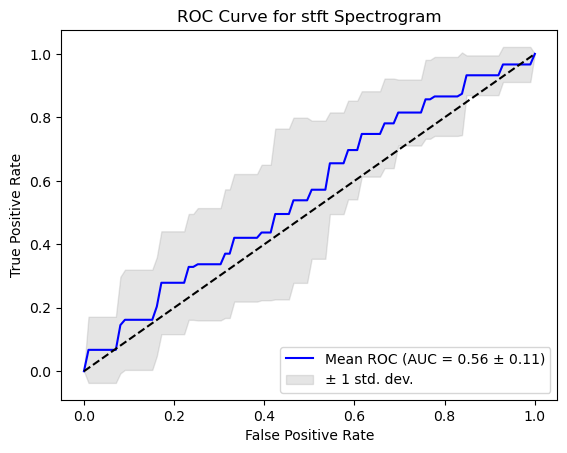


Mean and Std Dev of Performance Metrics for Spectrogram stft:
Fold                   5.500000
Accuracy              53.933333
F1 Score               0.484833
Precision              0.495471
Recall                 0.539333
Specificity            0.670513
Kappa                  0.061927
ROC AUC                0.560256
Training Time (s)    230.592513
Testing Time (s)       5.109386
dtype: float64
Fold                   3.027650
Accuracy               9.396348
F1 Score               0.119252
Precision              0.159832
Recall                 0.093963
Specificity            0.249538
Kappa                  0.193135
ROC AUC                0.117825
Training Time (s)    137.730937
Testing Time (s)       2.304409
dtype: float64


In [4]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['stft']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the ResNet50 model function
def build_resnet50_model(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_resnet50_model(input_shape, num_classes)

    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


Training model for spectrogram type: stft
Epoch 1/50
14/14 [==============================] - 2s 147ms/step - loss: 0.7164 - accuracy: 0.5545 - val_loss: 0.7154 - val_accuracy: 0.5600
Epoch 2/50
14/14 [==============================] - 2s 114ms/step - loss: 0.6386 - accuracy: 0.6227 - val_loss: 0.7027 - val_accuracy: 0.6400
Epoch 3/50
14/14 [==============================] - 2s 114ms/step - loss: 0.5916 - accuracy: 0.6909 - val_loss: 0.6902 - val_accuracy: 0.7200
Epoch 4/50
14/14 [==============================] - 2s 114ms/step - loss: 0.5586 - accuracy: 0.7045 - val_loss: 0.6894 - val_accuracy: 0.6800
Epoch 5/50
14/14 [==============================] - 2s 114ms/step - loss: 0.5248 - accuracy: 0.7955 - val_loss: 0.6773 - val_accuracy: 0.6800
Epoch 6/50
14/14 [==============================] - 2s 115ms/step - loss: 0.4955 - accuracy: 0.8409 - val_loss: 0.6758 - val_accuracy: 0.6800
Epoch 7/50
14/14 [==============================] - 2s 119ms/step - loss: 0.4764 - accuracy: 0.8364 - val_

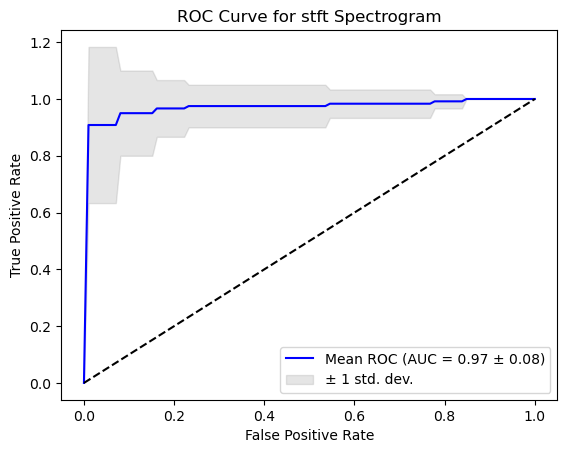


Mean and Std Dev of Performance Metrics for Spectrogram stft:
Fold                  5.500000
Accuracy             97.200000
F1 Score              0.971910
Precision             0.972052
Recall                0.972000
Specificity           0.976923
Kappa                 0.943730
ROC AUC               0.974359
Training Time (s)    24.698904
Testing Time (s)      0.639269
dtype: float64
Fold                  3.027650
Accuracy              8.854377
F1 Score              0.088829
Precision             0.088380
Recall                0.088544
Specificity           0.072976
Kappa                 0.177942
ROC AUC               0.081084
Training Time (s)    20.159456
Testing Time (s)      0.095840
dtype: float64


In [8]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['stft']


# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the MobileNetV2 model function
def build_mobilenetv2_model(input_shape, num_classes):
    base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_mobilenetv2_model(input_shape, num_classes)

    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


Training model for spectrogram type: stft
Epoch 1/50
60/60 [==============================] - 54s 904ms/step - loss: 0.6811 - accuracy: 0.5862 - val_loss: 0.6545 - val_accuracy: 0.6286
Epoch 2/50
60/60 [==============================] - 60s 992ms/step - loss: 0.6568 - accuracy: 0.6254 - val_loss: 0.6536 - val_accuracy: 0.6286
Epoch 3/50
60/60 [==============================] - 55s 921ms/step - loss: 0.6507 - accuracy: 0.6265 - val_loss: 0.6602 - val_accuracy: 0.6286
Epoch 4/50
60/60 [==============================] - 57s 953ms/step - loss: 0.6550 - accuracy: 0.6370 - val_loss: 0.6505 - val_accuracy: 0.6286
Epoch 5/50
60/60 [==============================] - 57s 942ms/step - loss: 0.6514 - accuracy: 0.6265 - val_loss: 0.6510 - val_accuracy: 0.6286
Epoch 6/50
60/60 [==============================] - 57s 946ms/step - loss: 0.6427 - accuracy: 0.6360 - val_loss: 0.6492 - val_accuracy: 0.6190
Epoch 7/50
60/60 [==============================] - 58s 966ms/step - loss: 0.6399 - accuracy: 0.6423

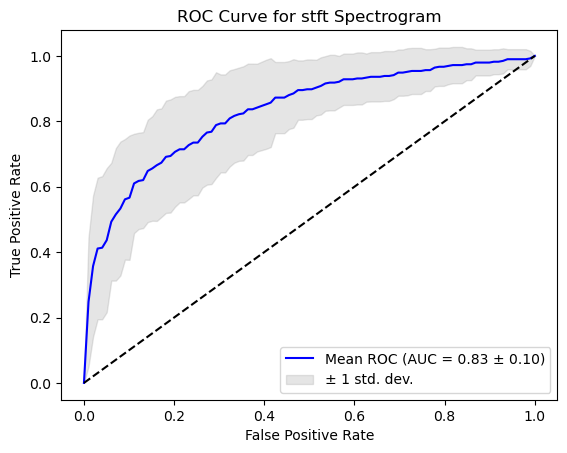


Mean and Std Dev of Performance Metrics for Spectrogram stft:
Fold                    5.500000
Accuracy               76.952381
F1 Score                0.746773
Precision               0.762832
Recall                  0.769524
Specificity             0.926900
Kappa                   0.459773
ROC AUC                 0.828796
Training Time (s)    1087.784056
Testing Time (s)        6.156533
dtype: float64
Fold                    3.027650
Accuracy                7.208517
F1 Score                0.103795
Precision               0.102051
Recall                  0.072085
Specificity             0.037969
Kappa                   0.202909
ROC AUC                 0.104056
Training Time (s)    1030.618734
Testing Time (s)        0.118215
dtype: float64


In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['stft']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the VGG19 model function
def build_vgg19_model(input_shape, num_classes):
    base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_vgg19_model(input_shape, num_classes)

    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)
